In [19]:
from __future__ import division
import os
import re
import yaml
import math
import time
import random
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [20]:
store = pd.HDFStore('store.h5')
df1 = store['df1']
df2 = store['df2']

In [21]:
path_to_file = os.path.realpath('.')

In [22]:
def getSets(df, index1, index2):
    total_words = 0
    i = 0 
    set1 = set()
    set2 = set()
    if 'text' in df.columns:
        for words in df.text[index1]:
            re_words = re.findall(r'\b[^\d\W]+\b', words)
            for word in re_words:
                set1.add(word)
        for words in df.text[index2]:
            re_words = re.findall(r'\b[^\d\W]+\b', words)
            for word in re_words:
                set2.add(word)
    else:
        for words in df.out_links[index1]:
            for word in words:
                set1.add(word)
        for words in df.out_links[index2]:
            for word in words:
                set2.add(word)
    return set1, set2

In [23]:
def countTFPerArticle(df):
    i = 0
    text_to_write = ''
    for article in df.text:
        j = 0
        re_words = re.findall(r'\b[^\d\W]+\b', article)
        re_words =  [x.lower() for x in re_words]
        counter = Counter(re_words)
        try:
            words, frqs = zip(*counter.most_common())
            text_to_write += df.name[i] + '= {' 
            while j < len(words):
                text_to_write +=  "'" + words[j] + "'" + ': ' + str(frqs[j]) +', '
                j += 1
                
        except Exception as e:
            pass        
        text_to_write += '}\r\n'
        i += 1
        
        if i%1000 == 0:
            with open(os.path.join(path_to_file, 'tf_per_article_dict.txt'), 'a') as file_to_write:
                file_to_write.write(text_to_write)
                file_to_write.close()
            text_to_write = ''
    with open(os.path.join(path_to_file, 'tf_per_article_dict.txt'), 'a') as file_to_write:
        file_to_write.write(text_to_write)
        file_to_write.close()

In [24]:
def countTFPerDoc(df):
    j = 0
    text_to_write = ''
    allwords = []
    for article in df.text:
        allwords += re.findall(r'\b[^\d\W]+\b', article)
    allwords =  [x.lower() for x in allwords]

    try:
        counter = Counter(allwords)
        words, frqs = zip(*counter.most_common())
    except Exception:
        pass
    text_to_write = '{'
    while j < len(words):
        text_to_write +=  "'" + words[j] + "'" + ': ' + str(frqs[j]) +', '
        j += 1
        if j%1000 == 0:
            with open(os.path.join(path_to_file, 'tf_per_doc.txt'), 'a') as file_to_write:
                file_to_write.write(text_to_write)
                file_to_write.close()
            text_to_write = ''
    text_to_write = '}'
    with open(os.path.join(path_to_file, 'tf_per_doc.txt'), 'a') as file_to_write:
        file_to_write.write(text_to_write)
        file_to_write.close()

In [25]:
def calcJaccardSimilarity(set1, set2):
    inter = 0
    union_set = set1.union(set2)
    union = len(union_set)
    for word in set1:
        if word in set2:
            inter += 1    

    return round(inter/union,4)

In [26]:
def calcTFIDF(df, dict1, dict2, dictN):
    corpus_len = len(df)
    dict_tfidf1 = {}
    dict_tfidf2 = {}

    #number of docs where the term x appears

    for key in dictN:
        #Doc1
        for key1 in dict1:
            if key1 == key:
                dict_tfidf1.update({key:dict1[key]/len(dict1) * math.log10(corpus_len/dictN[key]) })
        #Doc2
        for key2 in dict2:
            if key2 == key:
                dict_tfidf2.update({key: dict2[key]/len(dict2) * math.log10(corpus_len/dictN[key]) })
        
    return dict_tfidf1, dict_tfidf2


In [27]:
def calculateCosineSimilarity(tfidf1, tfidf2):
    v1 = []
    v2 = []
    vset1 = []
    vset2 = []
    dotp = 0
    i = 0
    for key1 in tfidf1:
        vset1.append(key1)
    for key2 in tfidf2:
        vset2.append(key2)
    #Get the sparse vectors
    for key1 in tfidf1:
        v1.append(1)
        if key1 in vset2:
            v2.append(1)
            del tfidf2[key1]
        else:
            v2.append(0)
    
    for key2 in tfidf2:
        v2.append(1)
        if key2 in vset1:
            v1.append(1)
        else:
            v1.append(0)
    
    #Get dot product
    while i < len(v1):
        dotp += v1[i]*v2[i]
        i += 1
    #Get the norms
    norm1 = math.sqrt(sum(v1))
    norm2 = math.sqrt(sum(v2))
    #calculate cos similarity
    cos_sim = dotp/(norm1*norm2)
    
    return round(cos_sim,4)

In [28]:
def dictionarize(name1, name2):
    dictN = {}
    name1 += '='
    name2 += '='
    dict1 = dict()
    dict2 = dict()
    size = 0
    file = open(os.path.join(path_to_file, 'tf_per_article_dict.txt'), 'r')
    for line in file:
        size += 1
        if name1 in line:
            name, words = line.split("=",1)
            words = words.replace(', }', '}')
            dict1 =yaml.load(words)
        if name2 in line:
            name, words = line.split("=",1)
            words = words.replace(', }', '}')
            dict2 =yaml.load(words)
        re_words = re.findall(r'\b[^\d\W]+\b', line)
        for re_word in re_words:
            if re_word in dictN:
                #Counts number of docs the word X appears
                dictN[re_word] += 1
            else:
                dictN.update({re_word: 1}) 
    file = open(os.path.join(path_to_file, 'tf_per_doc.txt'), 'r')
    for line in file:  
        words = words.replace(', }', '}')
        dict_all =yaml.load(words)
    return dict1, dict2, dict_all, dictN, size

In [29]:
def getIndexes(index1):
    index2 = random.randint(0,len(df1))
    while df1.text[index2] == '':
        index2 = random.randint(0,len(df1))
    if index1 == index2:
        if index1 == len(df1) -1:
            index2 = index2 -1
        else:
            index2 += 1
    return index2

In [30]:
def getLongest():
    length = []
    indexes = []
    for article in df1.text:
        length.append(len(article))
    for index in df1.index:
        indexes.append(index)
    
    list1, list2 = zip(*sorted(zip(length, indexes), reverse=True))
    return list(list2[:100])

In [31]:
def compareAll():
    cos = []
    jacc = []
    file = open(os.path.join(path_to_file, 'compare.txt'), 'r')
    for line in file:
        jacca = line.find('jaccard')
        jacc.append(line[jacca + len('jaccard') + 2 : line.find(',', jacca)] )
        cosi = line.find('cosine')
        cos.append(line[cosi + len('cosine') + 2 :line.find('}', cosi)])

    if np.argmax(jacc) == np.argmax(cos):
        print 'The most similar articles to a certain article always be the same independent which model we use'
    else:
        print 'With different models we get different articles'
    try:
        smirnov = [float(jacc1) - float(cos1) for jacc1, cos1 in zip(jacc, cos)]
    except Exception:
        pass        
    return smirnov

In [32]:
def buildRandom():
    i = 0
    text_to_write = ''
    index1 = 27444 #germany
    jaccardl = []
    cosinel = []
    while i < 100:
        index2 = getIndexes(index1)
        set1, set2 = getSets(df1, index1, index2)
        jaccard = calcJaccardSimilarity(set1, set2)
        dict11, dict21, dictall1, dictN1, size = dictionarize(df1.name[index1], df1.name[index2])
        tdfidf11, tdfidf21 = calcTFIDF(df1,dict11,dict21,dictN1)
        cos_sim = calculateCosineSimilarity(tdfidf11, tdfidf21)
        jaccardl.append(jaccard)
        cosinel.append(cos_sim)
        text_to_write += "{" + df1.name[index1]+ ":{" +df1.name[index2] + ":{" + "\'jaccard\':" + str(jaccard) + ", \'cosine\':" + str(cos_sim)+ '}}} \r\n'
        i += 1
    with open(os.path.join(path_to_file, 'compare.txt'), 'w') as file_to_write:
        file_to_write.write(text_to_write)
        file_to_write.close()
    return jaccardl, cosinel

In [33]:
def buildLongest():
    i = 0
    text_to_write = ''
    index1 = 27444 #germany
    jaccardl = []
    cosinel = []
    longest = getLongest()
    while i < 100:
        index2 = longest.pop()
        set1, set2 = getSets(df1, index1, index2)
        jaccard = calcJaccardSimilarity(set1, set2)
        dict11, dict21, dictall1, dictN1, size = dictionarize(df1.name[index1], df1.name[index2])
        tdfidf11, tdfidf21 = calcTFIDF(df1,dict11,dict21,dictN1)
        cos_sim = calculateCosineSimilarity(tdfidf11, tdfidf21)
        jaccardl.append(jaccard)
        cosinel.append(cos_sim)
        text_to_write += "{" + df1.name[index1]+ ":{" +df1.name[index2] + ":{" + "\'jaccard\':" + str(jaccard) + ", \'cosine\':" + str(cos_sim)+ '}}} \r\n'
        i += 1
    with open(os.path.join(path_to_file, 'compare.txt'), 'w') as file_to_write:
        file_to_write.write(text_to_write)
        file_to_write.close()
    return jaccardl, cosinel

In [34]:
index1 = df1.index[df1.name=="Germany"]
index2 = df1.index[df1.name=="Europe"]
set1, set2 = getSets(df1, index1, index2)

In [17]:
jaccard = calcJaccardSimilarity(set1, set2)
print 'Jaccard similarity for Germany and Europe is ' + str(jaccard)

Jaccard similarity for Germany and Europe is 0.0444


In [18]:
if not os.path.isfile('tf_per_article_dict.txt'):
    countTFPerArticle(df1)

In [136]:
if not os.path.isfile('tf_per_doc.txt'):
    countTFPerDoc(df1)

In [35]:
dict1, dict2, dictall, dictN, size = dictionarize('Germany', 'Europe')


In [36]:
tdfidf1, tdfidf2 = calcTFIDF(df1,dict1,dict2,dictN)

In [37]:
cos_sim = calculateCosineSimilarity(tdfidf1, tdfidf2)
print 'Cosine similarity for Germany and Europe is ' + str(cos_sim)

Cosine similarity for Germany and Europe is 0.1803


In [38]:
set1, set2 = getSets(df2, index1, index2)
jaccard = calcJaccardSimilarity(set1, set2)
print 'Jaccard similarity for Germany and Europe (Out links) is ' + str(jaccard)

Jaccard similarity for Germany and Europe (Out links) is 0.2731


In [39]:
before = time.clock()
jaccardl, cosinel = buildRandom()
after = time.clock()


In [40]:
comparisson = compareAll()

With different models we get different articles


In [41]:
elapsed_time = after - before
print 'Elapsed time to calculate 100 similarities ' + str(round(elapsed_time/60,2)) + ' minutes'

Elapsed time to calculate 100 similarities 10.53 minutes


In [42]:
time_for_all_to_one = size * elapsed_time / 100
time_for_all = time_for_all_to_one * size
print str(time_for_all) + ' minutes'

5128390383.81 minutes


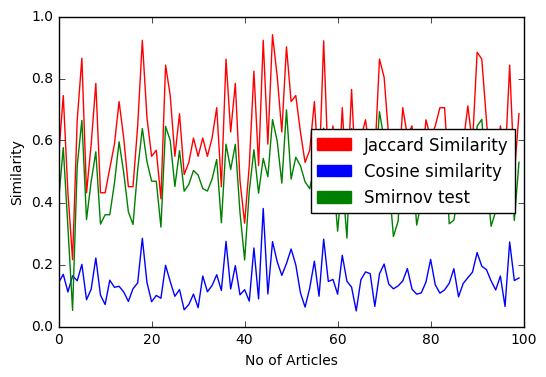

In [43]:
plt.plot(jaccardl, 'r-')
plt.plot(cosinel, 'b-')
plt.plot(comparisson, 'g-')

# adds labels to the axis
plt.ylabel('Similarity')
plt.xlabel('No of Articles')
# generates legend
jacc_legend = mpatches.Patch(color='red', label='Jaccard Similarity')
cos_legend = mpatches.Patch(color='blue', label='Cosine similarity')
comp_legend = mpatches.Patch(color='green', label='Smirnov test')
plt.legend(handles=[jacc_legend, cos_legend, comp_legend ], loc=5)
plt.show()

In [44]:
before = time.clock()
jaccardl, cosinel = buildLongest()
after = time.clock()

In [45]:
comparisson = compareAll()

With different models we get different articles


In [46]:
total_computations = size * size
print total_computations

812079009


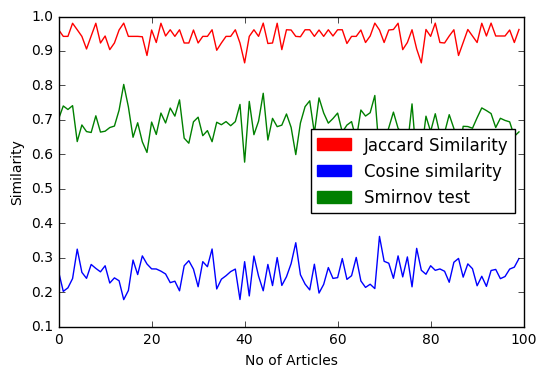

In [47]:
plt.plot(jaccardl, 'r-')
plt.plot(cosinel, 'b-')
plt.plot(comparisson, 'g-')

# adds labels to the axis
plt.ylabel('Similarity')
plt.xlabel('No of Articles')
# generates legend
jacc_legend = mpatches.Patch(color='red', label='Jaccard Similarity')
cos_legend = mpatches.Patch(color='blue', label='Cosine similarity')
comp_legend = mpatches.Patch(color='green', label='Smirnov test')
plt.legend(handles=[jacc_legend, cos_legend, comp_legend ], loc=5)
plt.show()